# Chapter 12 - Notes

## Set Up

### Packages

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats
from scipy.special import expit, logit, softmax
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [3]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
CHIMPANZEES_FILE = "chimpanzees.csv"
ADMISSIONS_FILE = "ucbadmit.csv"
KLINE_FILE = "kline.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

## 12.1 Over-dispersed counts

### 12.1.1 Beta-binomial

Let's take a look at the Beta distribution for a few values of the parameters.

There are few different parameterisations floating around.
Both SciPy and PyMC give parameterisations in terms of $\alpha$ and $\beta$.
The book has $\bar{p}$ and $\theta$.
These are $\mu$ (the mean) and $\kappa$ in PyMC.
So we have the following conversions:

\begin{align}
    \alpha & = \bar{p}\theta & \bar{p} & = \frac{\alpha}{\alpha + \beta} & \mu & = \bar{p},\\
    \beta & = (1 - \bar{p})\theta & \theta & = \alpha + \beta & \sigma^2 & = \frac{p(1-p)}{\theta + 1} = \frac{\alpha\beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}.\\
\end{align}

In [5]:
def beta_pdf(x_val, pbar, theta):
    a = pbar * theta
    b = (1 - pbar) * theta
    return stats.beta.pdf(x_val, a=a, b=b)

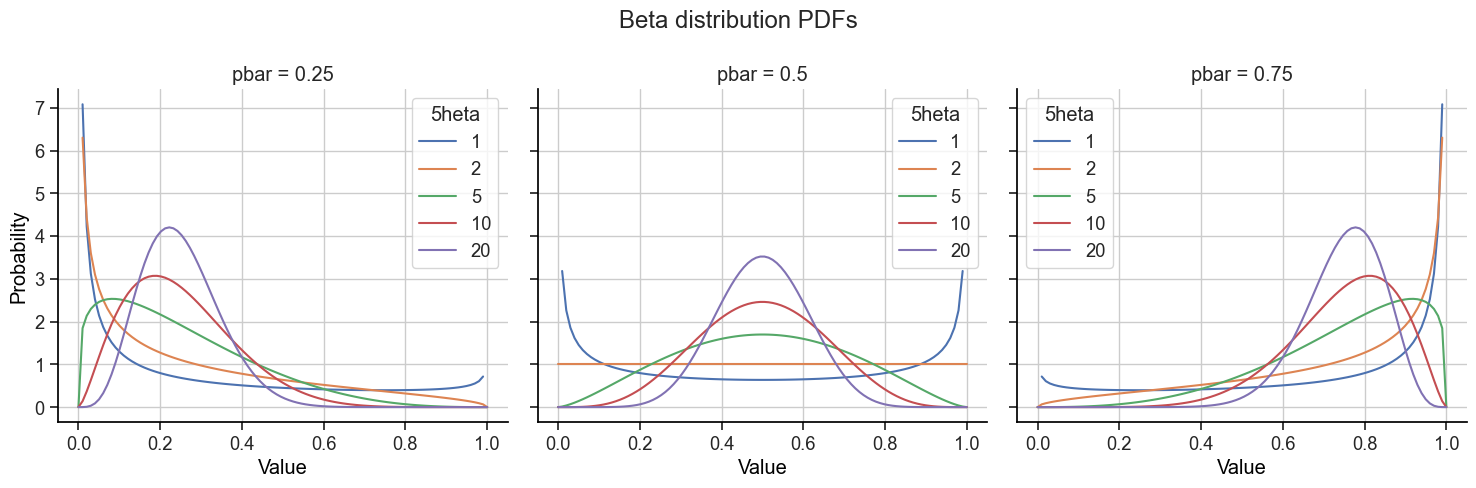

In [6]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))

pbars = np.array([0.25, 0.5, 0.75])
thetas = np.array([1, 2, 5, 10, 20])

x_val = np.linspace(0, 1, 100)
for pbar, ax in zip(pbars, axs):
    for theta in thetas:
        ax.plot(x_val, beta_pdf(x_val, pbar, theta), label=str(theta))

    ax.set(xlabel="Value", title=f"pbar = {pbar}")
    ax.legend(title="5heta")

axs[0].set(ylabel="Probability")

fig.suptitle("Beta distribution PDFs")
fig.tight_layout();

Now let's fit a model using the admissions data.

Load the data.

In [7]:
# load the data
admit = load_data(ADMISSIONS_FILE, delimiter=";")

# cleaning
admit = admit.rename(
    columns={
        "applicant.gender": "gender",
    }
)

admit["admission_rate"] = admit["admit"] / admit["applications"]

# create index variables
admit["gender_idx"], genders = pd.factorize(admit["gender"])
admit["dept_idx"], depts = pd.factorize(admit["dept"])

Specify the model.

In [8]:
coords = {
    "obs": admit.index,
    "gender": genders,
}
with pm.Model(coords=coords) as m12_1:
    # data
    gender_idx = pm.MutableData("gender_idx", admit.gender_idx, dims="obs")
    applications = pm.MutableData("applications", admit.applications, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1.5, dims="gender")
    phi = pm.Exponential("phi", lam=1)

    # derived values
    pbar = pm.Deterministic("pbar", pm.math.invlogit(alpha[gender_idx]), dims="obs")
    theta = pm.Deterministic("theta", phi + 2)

    # likelihood
    admissions = pm.BetaBinomial(
        "admissions",
        n=applications,
        alpha=pbar * theta,
        beta=(1 - pbar) * theta,
        observed=admit.admit,
        dims="obs",
    )
    admission_rate = pm.Deterministic(
        "admission_rate", admissions / applications, dims="obs"
    )

    # gender contract
    gender_contrast = pm.Deterministic("gender_contrast", alpha[0] - alpha[1])

    # inference button
    trace_12_1 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


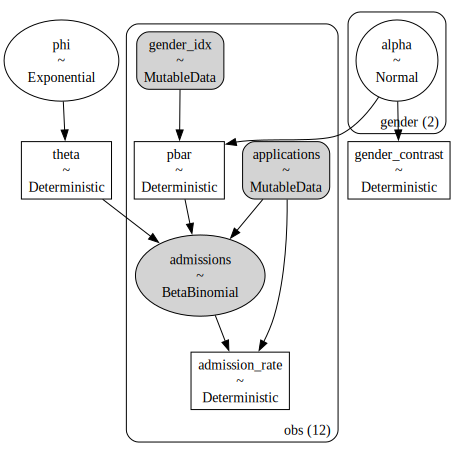

In [9]:
m12_1.to_graphviz()

Inspect the posteriors

In [10]:
az.summary(
    trace_12_1,
    var_names=["alpha", "theta", "gender_contrast"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[male],-0.45,0.42,-1.12,0.19
alpha[female],-0.32,0.42,-1.01,0.32
theta,3.03,0.81,2.00,4.06
gender_contrast,-0.13,0.59,-1.08,0.77


Let's sample some posterior values of $\bar{p}$ and $\theta$ and plot the corresponding Beta distributions.
We also want to plot the MAP.

Finally we also do a posterior validation check with prediction intervals by department.

Start by fetching the MAP.

In [11]:
with m12_1:
    map_ = pm.find_MAP()

    trace_12_1 = pm.sample_posterior_predictive(
        trace_12_1,
        var_names=["admissions", "admission_rate"],
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )

Sampling: [admissions]


In [12]:
def plot_female_posterior_curves(trace, map_, n_lines=100, lines_alpha=0.1, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 4))

    # plot the MAP distribution
    alpha_map = map_["alpha"][1]
    theta_map = map_["theta"]

    x_val = np.linspace(0, 1, 500)
    ax.plot(x_val, beta_pdf(x_val, expit(alpha_map), theta_map), color="k")

    # now plot a selection of distributions
    alphas = (
        trace.posterior.alpha.sel(gender="female", chain=0)
        .isel(draw=slice(n_lines))
        .values
    )
    thetas = trace.posterior.theta.sel(chain=0).isel(draw=slice(n_lines)).values

    pbars = expit(alphas)
    x_val = np.linspace(0, 1, 100)
    for pbar, theta in zip(pbars, thetas):
        ax.plot(
            x_val,
            beta_pdf(x_val, pbar, theta),
            color="k",
            alpha=lines_alpha,
        )

    ax.set(
        xlabel="Probability of admission",
        ylabel="Density",
        title="Distribution of female admissions rates",
    );

In [13]:
def plot_posterior_preditive_checks_by_observation(
    admit, trace, hdi_prob=0.89, ax=None
):
    if not ax:
        fig, ax = plt.subplots(figsize=(7, 3))

    sns.scatterplot(
        x=admit.index,
        y=admit.admission_rate,
        ax=ax,
    )
    for dept in depts:
        dept_data = admit[admit["dept"] == dept]
        ax.plot(
            dept_data.index,
            dept_data.admission_rate,
            color=colors[0],
        )

    sns.scatterplot(
        x=admit.index,
        y=trace.posterior.pbar.mean(dim=["draw", "chain"]),
        facecolors="none",
        edgecolor="k",
        linewidth=1,
    )

    pbar_hdi = az.hdi(trace.posterior.pbar, hdi_prob=0.89)
    ax.plot(
        [admit.index, admit.index],
        [pbar_hdi.pbar.sel(hdi="lower"), pbar_hdi.pbar.sel(hdi="higher")],
        color="k",
    )

    admission_rate_hdi = az.hdi(
        trace.posterior_predictive.admission_rate, hdi_prob=0.89
    )
    for hdi in admission_rate_hdi.hdi.values:
        sns.scatterplot(
            x=admit.index,
            y=admission_rate_hdi.admission_rate.sel(hdi=hdi),
            marker="+",
            color="k",
            linewidth=1,
        )

    ax.set(
        ylim=[-0.05, 1],
        xlabel="Observation",
        ylabel="Admission rate",
        title="Posterior validation check",
    );

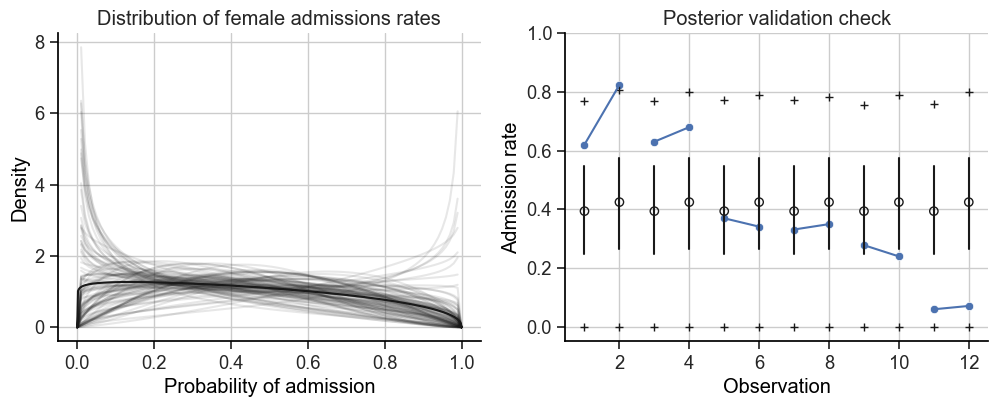

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

plot_female_posterior_curves(trace_12_1, map_, ax=axs[0])
plot_posterior_preditive_checks_by_observation(admit, trace_12_1, ax=axs[1])

### 12.1.1 Negative-binomial or gamma-Poisson

We start with the Gamma distribution.
This has two common parameterisations.
Firstly, $\text{Gamma}\left( k, \theta \right)$  with *shape* parameter $k > 0$ and *scale* parameter $\theta > 0$.
With this notation, the mean is $\mu = k\theta$ and the variance is $\sigma^2 = k \theta^2$.

The other parameterisation is $\text{Gamma}\left( k, \theta \right)$ with *shape* parameter $\alpha > 0$ and *rate* parameter $\beta > 0$.
This has mean $\mu = \frac{\alpha}{\beta}$ and variance $\sigma^2 = \frac{\alpha}{\beta^2}$.
It's easy to switch between these parameterisations:

\begin{align}
    \alpha & = k, & \beta & = \frac{1}{\theta}.
\end{align}

The negative-binomial/gamma-Poisson distribution has two different parameterisations arising from the two derivations.
Both the book and PyMC come from the gamma-Poisson perspective with parameters $\lambda, \phi$ and $\mu, \alpha$, respectively.
Using the PyMC notation, $\mu$ is the mean and the variance is $\sigma^2 = \mu + \frac{\mu^2}{\alpha}$.

This corresponds to sampling from a Poisson distribution whose single parameter is sampled from a Gamma distribution $\text{Gamma}\left(\alpha=\alpha, \beta=\frac{\alpha}{\mu}\right)$.
Note that this underlying Gamma distribution has mean $\mu$ and variance $\frac{\mu^2}{\alpha}$.

Scipy has a parameterisation coming from the binomial perspective, with parameters of $p$ and $n$.
This describes the number of Bernoulli trials with probability of success $p$ until $n$ successes occur.
This has mean $\mu=\frac{n(1-p)}{p}$ and variance $\sigma^2 = \frac{n(1-p)}{p^2}$.
Although in this formulation it only makes sense for $n$ to be an integer, it can actually be any positive number.

We can pass between these parameterisations as follows:

\begin{align}
    p & = \frac{\alpha}{\mu + \alpha}, & \mu & = \frac{n(1-p)}{p}, \\
    n & = \alpha, & \alpha & = n.
\end{align}

Now let's plot some gamma-Poission distributions with the underlying Gamma distributions.

In [15]:
def gamma_pdf(mu, alpha):
    a = alpha

    beta = alpha / mu
    scale = 1 / beta

    rv = stats.gamma(a=a, scale=scale)
    x_val = np.linspace(
        rv.ppf(0.0001),
        rv.ppf(0.9999),
        1000,
    )
    return (x_val, rv.pdf(x_val))


def gamma_poisson_pmf(mu, alpha):
    n = alpha
    p = alpha / (mu + alpha)

    rv = stats.nbinom(p=p, n=n)
    x_val = np.arange(rv.ppf(0.99))
    return (x_val, rv.pmf(x_val))

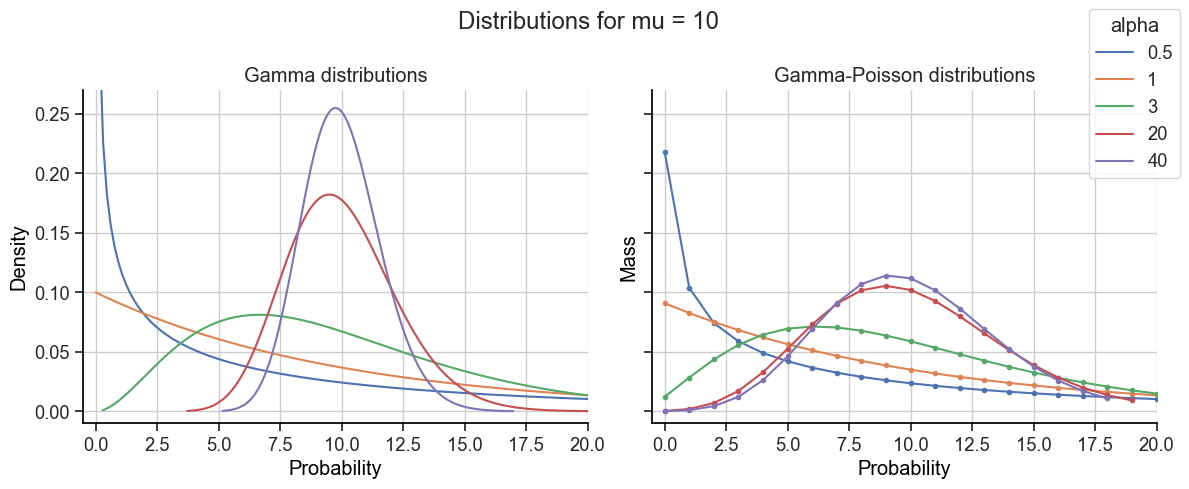

In [16]:
mu = 10
alphas = np.array([0.5, 1, 3, 20, 40])

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))

for ix, alpha in enumerate(alphas):
    color = colors[ix]
    if int(alpha) == alpha:
        label = str(int(alpha))
    else:
        label = str(alpha)

    axs[0].plot(*gamma_pdf(mu, alpha), color=color, label=label)
    axs[1].plot(*gamma_poisson_pmf(mu, alpha), marker=".", color=color)

axs[0].set(
    xlim=[-0.5, 20],
    ylim=[-0.01, 0.27],
    xlabel="Probability",
    ylabel="Density",
    title="Gamma distributions",
)
axs[1].set(
    xlim=[-0.5, 20],
    ylim=[-0.01, 0.27],
    xlabel="Probability",
    ylabel="Mass",
    title="Gamma-Poisson distributions",
)

fig.legend(title="alpha")
fig.suptitle("Distributions for mu = 10")
fig.tight_layout();

Now let's try re-doing the Oceanic tools example with a gamma-Poisson distribution.

In [17]:
# load data
kline = load_data(KLINE_FILE, delimiter=";")

kline["population"] = kline["population"].astype(float)

# transform features
kline["log_pop"] = np.log(kline.population)

kline_normaliser = StandardScaler().set_output(transform="pandas")
kline[["log_pop_norm"]] = kline_normaliser.fit_transform(kline[["log_pop"]])

# create index variable
kline["contact_id"] = (kline["contact"] == "high").astype(int)
contacts = ["low", "high"]

First we redefine the original Poisson model

In [18]:
cultures = kline.culture.values
contacts = ["low", "high"]

coords = {
    "culture": cultures,
    "contact": contacts,
}
# note that setting mutable coords will allow us to change them for counterfactuals
with pm.Model(coords_mutable=coords) as m11_10:
    # data
    population = pm.MutableData("population", kline.population, dims="culture")
    log_pop_norm = pm.MutableData("log_pop_norm", kline.log_pop_norm, dims="culture")
    contact_id = pm.MutableData("contact_id", kline.contact_id, dims="culture")

    # priors
    alpha = pm.Normal("alpha", mu=3, sigma=0.5, dims="contact")
    beta = pm.Normal("beta", mu=0, sigma=0.2, dims="contact")

    # model
    mu = pm.Deterministic(
        "mu",
        pm.math.exp(alpha[contact_id] + beta[contact_id] * log_pop_norm),
        dims="culture",
    )

    # likelihood
    total_tools = pm.Poisson(
        "total_tools", mu=mu, observed=kline.total_tools, dims="culture"
    )

    # sample prior predictive
    trace_11_10 = pm.sample(draws=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


Now we replace the Poission likelihood with a gamma-Poisson and add a prior on the dispersion parameter $\phi$.
Note that this looks different from the one in the book as they are adapting the 'clever' model 11.11, not the naive model 11.10.

In [19]:
cultures = kline.culture.values
contacts = ["low", "high"]

coords = {
    "culture": cultures,
    "contact": contacts,
}
with pm.Model(coords_mutable=coords) as m12_12:
    # data
    population = pm.MutableData("population", kline.population, dims="culture")
    log_pop_norm = pm.MutableData("log_pop_norm", kline.log_pop_norm, dims="culture")
    contact_id = pm.MutableData("contact_id", kline.contact_id, dims="culture")

    # priors
    alpha = pm.Normal("alpha", mu=3, sigma=0.5, dims="contact")
    beta = pm.Normal("beta", mu=0, sigma=0.2, dims="contact")
    phi = pm.Exponential("phi", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        pm.math.exp(alpha[contact_id] + beta[contact_id] * log_pop_norm),
        dims="culture",
    )

    # likelihood
    total_tools = pm.NegativeBinomial(
        "total_tools", mu=mu, alpha=phi, observed=kline.total_tools, dims="culture"
    )

    # sample prior predictive
    trace_12_12 = pm.sample(draws=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, phi]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


Now we copy over some functions from chapter 11 to allow us to plot posterior distributions by contact.

In [20]:
def sample_kline_counterfactuals_by_contact(model, trace, normaliser, n_samples=100):
    population_seq = np.linspace(500, 300000, n_samples)
    log_pop_seq = np.log(population_seq)
    log_pop_norm_seq = normaliser.transform(log_pop_seq.reshape(-1, 1))[
        "log_pop"
    ].values

    with model:
        pm.set_data(
            {
                "population": population_seq,
                "log_pop_norm": log_pop_norm_seq,
                "contact_id": np.zeros(n_samples, dtype=int),
            },
            coords={"culture": np.arange(n_samples)},
        )
        low_contact_pp = pm.sample_posterior_predictive(
            trace,
            var_names=["mu", "total_tools"],
            predictions=True,
            random_seed=RANDOM_SEED,
        )

        pm.set_data(
            {
                "population": population_seq,
                "log_pop_norm": log_pop_norm_seq,
                "contact_id": np.ones(n_samples, dtype=int),
            },
            coords={"culture": np.arange(n_samples)},
        )
        high_contact_pp = pm.sample_posterior_predictive(
            trace,
            var_names=["mu", "total_tools"],
            predictions=True,
            random_seed=RANDOM_SEED,
        )

    return low_contact_pp, high_contact_pp


def plot_posterior_predictive_regression_line(
    predictor_data, posterior_data, color=None, hdi_prob=0.89, ax=None
):
    if not ax:
        fig, ax = plt.subplots(figsize=(5, 4))

    ax.plot(
        predictor_data,
        posterior_data.mean(dim=["chain", "draw"]),
        color=color,
    )

    posterior_name = posterior_data.name
    hdi = az.hdi(posterior_data, hdi_prob=hdi_prob)[posterior_name]
    ax.fill_between(
        predictor_data,
        hdi.sel(hdi="lower"),
        hdi.sel(hdi="higher"),
        color=color,
        alpha=0.3,
    )


def plot_kline_posterior_regression_lines_by_contact(
    kline, low_contact_pp, high_contact_pp, x_col, ax=None
):
    if x_col not in ["log_pop_norm", "population"]:
        raise ValueError("x_col must be either 'log_pop_norm' or 'population'")

    if not ax:
        fig, ax = plt.subplots(figsize=(6, 5))

    hue_order = contacts
    sns.scatterplot(
        data=kline,
        x=x_col,
        y="total_tools",
        hue="contact",
        hue_order=hue_order,
        ax=ax,
    )

    plot_posterior_predictive_regression_line(
        low_contact_pp.predictions_constant_data[x_col],
        low_contact_pp.predictions.mu,
        color=colors[0],
        ax=ax,
    )

    plot_posterior_predictive_regression_line(
        high_contact_pp.predictions_constant_data[x_col],
        high_contact_pp.predictions.mu,
        color=colors[1],
        ax=ax,
    )

/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Sampling: [total_tools]


Sampling: [total_tools]


/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Sampling: [total_tools]


Sampling: [total_tools]


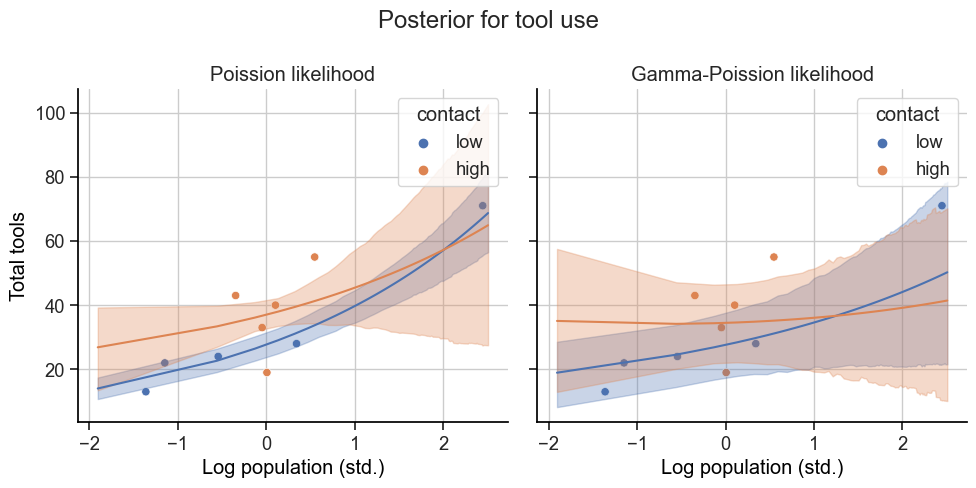

In [21]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

low_contact_pp_11_10, high_contact_pp_11_10 = sample_kline_counterfactuals_by_contact(
    m11_10, trace_11_10, kline_normaliser
)
plot_kline_posterior_regression_lines_by_contact(
    kline, low_contact_pp_11_10, high_contact_pp_11_10, x_col="log_pop_norm", ax=axs[0]
)

low_contact_pp_12_12, high_contact_pp_12_12 = sample_kline_counterfactuals_by_contact(
    m12_12, trace_12_12, kline_normaliser
)
plot_kline_posterior_regression_lines_by_contact(
    kline, low_contact_pp_12_12, high_contact_pp_12_12, x_col="log_pop_norm", ax=axs[1]
)

axs[0].set(
    xlabel="Log population (std.)",
    ylabel="Total tools",
    title="Poission likelihood",
)
axs[1].set(
    xlabel="Log population (std.)",
    title="Gamma-Poission likelihood",
)

fig.suptitle("Posterior for tool use")
fig.tight_layout();

Note that the gamma-Poisson model is much less effected by Hawaii and has much higher uncertainty.

Plotting against untransformed population on the $x$-axis shows how much uncertainty there is as population increases.
In the book this is mitigated by having a more scientifically motivated model that, for example, enforces no tool use at zero population.

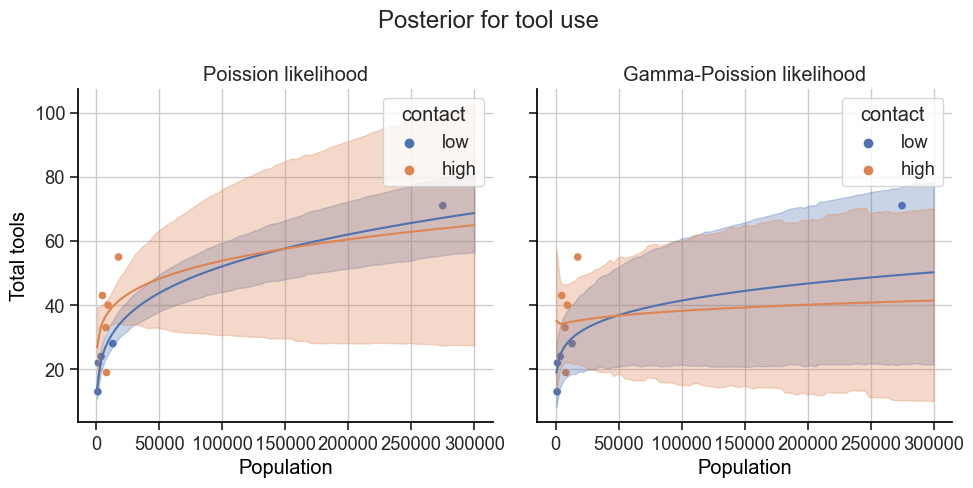

In [22]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

plot_kline_posterior_regression_lines_by_contact(
    kline, low_contact_pp_11_10, high_contact_pp_11_10, x_col="population", ax=axs[0]
)
plot_kline_posterior_regression_lines_by_contact(
    kline, low_contact_pp_12_12, high_contact_pp_12_12, x_col="population", ax=axs[1]
)

axs[0].set(
    xlabel="Population",
    ylabel="Total tools",
    title="Poission likelihood",
)
axs[1].set(
    xlabel="Population",
    title="Gamma-Poission likelihood",
)

fig.suptitle("Posterior for tool use")
fig.tight_layout();

## 12.2 Zero-inflated outcomes

### 12.2.1 Example: Zero-inflated Poisson

Simulate data

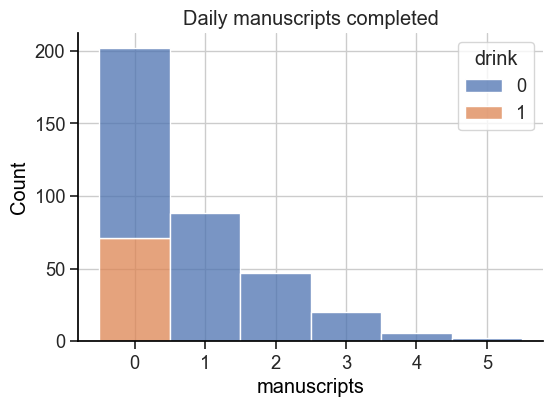

In [23]:
prob_drink = 0.2
rate_work = 1

n_samples = 365

# number of days monks drink
drink = stats.bernoulli.rvs(size=n_samples, p=prob_drink, random_state=RANDOM_SEED)

# number of manuscripts completed
y = (1 - drink) * stats.poisson.rvs(
    size=n_samples, mu=rate_work, random_state=RANDOM_SEED
)

# collect the data
monks = pd.DataFrame(
    index=pd.Index(range(n_samples), name="day"),
    data={
        "drink": drink,
        "manuscripts": y,
    },
)

# plot histogram of counts
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(
    monks, x="manuscripts", hue="drink", discrete=True, multiple="stack", ax=ax
)
ax.set(title="Daily manuscripts completed");

Now let's create a model.
PyMC actually has zero-inflated Poisson distributions we can use, but it'll be good practice to make my own.
We need two ingredients
- Log probability function (for sampling)
- A sampling function (for prior/posterior predictive sampling)

Note that the order of the arguments is crucial here.
Note also that the inputs and outputs must be `TensorVariables`.
This means that we must use PyMC's math functions in place of NumPy.

In [24]:
# functions for factln(k) = ln(k!) and logpw(a, b) = ln(a^b)
from pymc.distributions.dist_math import factln, logpow


def zipoisson_logp(value, p, mu):
    return pm.math.where(
        pm.math.eq(value, 0),
        pm.math.log(p + (1 - p) * pm.math.exp(-mu)),
        pm.math.log(1 - p) + logpow(mu, value) - factln(value) - mu,
    )


# rng is a numpy Generator, e.g. np.random.default_rng(seed=42)
def zipoisson_rvs(p, mu, rng=None, size=None):
    return (1 - rng.binomial(n=1, p=p, size=size)) * rng.poisson(lam=mu, size=size)

In [25]:
coords = {
    "day": monks.index,
}
with pm.Model(coords=coords) as m12_3a:
    # # priors
    alpha_p = pm.Normal("alpha_p", mu=-1.5, sigma=1.0)
    alpha_mu = pm.Normal("alpha_mu", mu=1.0, sigma=0.5)

    # link functions
    p = pm.Deterministic("p", pm.math.invlogit(alpha_p))
    mu = pm.Deterministic("mu", pm.math.exp(alpha_mu))

    # likelihood
    manuscripts = pm.CustomDist(
        "manuscripts",
        p,
        mu,
        logp=zipoisson_logp,
        random=zipoisson_rvs,
        observed=monks.manuscripts,
        dims="day",
    )

    # sample
    trace_12_3a = pm.sample(random_seed=RANDOM_SEED)

az.summary(trace_12_3a)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_p, alpha_mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_p,-0.649,0.214,-1.062,-0.268,0.005,0.004,1679.0,1764.0,1.0
alpha_mu,0.161,0.086,0.006,0.319,0.002,0.001,1721.0,1984.0,1.0
p,0.345,0.047,0.257,0.434,0.001,0.001,1679.0,1764.0,1.0
mu,1.178,0.101,1.006,1.376,0.002,0.002,1721.0,1984.0,1.0


We can also do this with the in-built zero-inflated Poisson distribution:

In [26]:
coords = {
    "day": monks.index,
}
with pm.Model(coords=coords) as m12_3a:
    # # priors
    alpha_p = pm.Normal("alpha_p", mu=-1.5, sigma=1.0)
    alpha_mu = pm.Normal("alpha_mu", mu=1.0, sigma=0.5)

    # link functions
    p = pm.Deterministic("p", pm.math.invlogit(alpha_p))
    mu = pm.Deterministic("mu", pm.math.exp(alpha_mu))

    # likelihood
    manuscripts = pm.ZeroInflatedPoisson(
        "manuscripts",
        psi=1 - p,
        mu=mu,
        observed=monks.manuscripts,
        dims="day",
    )

    # sample
    trace_12_3b = pm.sample(random_seed=RANDOM_SEED)

az.summary(trace_12_3b)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_p, alpha_mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_p,-0.645,0.216,-1.070,-0.268,0.005,0.004,1619.0,1810.0,1.0
alpha_mu,0.161,0.086,0.005,0.319,0.002,0.002,1649.0,1854.0,1.0
p,0.346,0.048,0.255,0.433,0.001,0.001,1619.0,1810.0,1.0
mu,1.179,0.101,1.005,1.376,0.002,0.002,1649.0,1854.0,1.0
